# PRODIGY InfoTech Task-5-1.1
Analyze traffic accident data to identify patterns related to road conditions, weather, and time of day. Visualize accident hotspots and contributing factors.

Dataset :- https://www.kaggle.com/code/harshalbhamare/us-accident-eda

In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

from sklearn.svm import LinearSVC

from sklearn.metrics import confusion_matrix , accuracy_score, log_loss, mean_squared_error
from sklearn import metrics
from sklearn.metrics import classification_report

pd.set_option('display.max_columns',None)

E:\Anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# We take the oversampling dataset from Clustering
df = pd.read_csv('sample.csv')
df.shape

(100000, 46)

In [4]:
df.head(2)

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Street,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1154700,Source3,2,2021-02-12 08:22:52,2021-02-12 10:34:23,40.726833,-73.375107,NaN,NaN,0.0,One lane blocked due to accident on Southern P...,Southern State Pkwy W,West Babylon,Suffolk,NY,11704,US,US/Eastern,KFRG,2021-02-12 07:53:00,20.0,9.0,40.0,30.26,10.0,N,10.0,0.0,Fair,False,False,False,False,True,False,False,False,False,False,False,False,False,Day,Day,Day,Day
1,A-7326903,Source1,2,2019-10-03 07:42:00,2019-10-03 08:53:59,35.446737,-120.638870,35.446737,-120.63887,0.0,At Santa Barbara Rd/Exit 216A - Accident.,El Camino Real S,Atascadero,San Luis Obispo,CA,93422,US,US/Pacific,KPRB,2019-10-03 07:53:00,42.0,42.0,67.0,29.12,NaN,CALM,0.0,0.0,Fair,False,False,False,False,True,False,False,False,False,False,False,False,False,Day,Day,Day,Day


In [5]:
df = df.drop(['ID','Description','End_Lat', 'End_Lng','Country', 'Pressure(in)','Weather_Condition','Timezone','Zipcode','Airport_Code','Street'], axis=1)

df= df.rename(columns = {'Distance(mi)' : 'Distance_mi','Temperature(F)' : 'Temperature_F' ,'Wind_Chill(F)':'Wind_Chill_F',
                         'Humidity(%)' : 'Humidity_percentage' , 'Visibility(mi)': 'Visibility_mi',
                           'Wind_Speed(mph)': 'Wind_Speed_mph', 'Precipitation(in)': 'Precipitation_in' })
df.shape

(100000, 35)

<span style="font-size: 1.5em;">__Preprocessing__ </span>

In [6]:
df.columns

Index(['Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'Distance_mi', 'City', 'County', 'State',
       'Weather_Timestamp', 'Temperature_F', 'Wind_Chill_F',
       'Humidity_percentage', 'Visibility_mi', 'Wind_Direction',
       'Wind_Speed_mph', 'Precipitation_in', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

In [7]:
# Create features from Start_Time and End_Time

df['Start_Time'] = pd.to_datetime(df['Start_Time'])
df['Start_Year'] = df['Start_Time'].dt.year
nmonth = df['Start_Time'].dt.month
df['Start_Month'] = nmonth
df['Start_Weekday']= df['Start_Time'].dt.weekday
days_each_month = np.cumsum(np.array([0,31,28,31,30,31,30,31,31,30,31,30,31]))
nday = [days_each_month[arg-1] for arg in nmonth.values]
nday = nday + df["Start_Time"].dt.day.values
df['Start_Day'] = nday
df['Start_Hour'] = df['Start_Time'].dt.hour
df['Start_Minute']=df['Start_Hour']*60.0+df["Start_Time"].dt.minute


df['End_Time'] = pd.to_datetime(df['End_Time'])
df['End_Year'] = df['End_Time'].dt.year
month = df['End_Time'].dt.month
df['End_Month'] = month
df['End_Weekday']= df['End_Time'].dt.weekday
days_each_month = np.cumsum(np.array([0,31,28,31,30,31,30,31,31,30,31,30,31]))
day = [days_each_month[arg-1] for arg in month.values]
day = day + df["End_Time"].dt.day.values
df['End_Day'] = day
df['End_Hour'] = df['End_Time'].dt.hour
df['End_Minute']=df['End_Hour']*60.0+df["End_Time"].dt.minute

df['Duration'] = round((df['End_Time']-df['Start_Time'])/np.timedelta64(1,'m'))

df[['Duration','Start_Year','Start_Month','Start_Weekday','Start_Day','Start_Hour','Start_Minute',
    'End_Year','End_Month','End_Weekday','End_Day','End_Hour','End_Minute']].head()

,Duration,Start_Year,Start_Month,Start_Weekday,Start_Day,Start_Hour,Start_Minute,End_Year,End_Month,End_Weekday,End_Day,End_Hour,End_Minute
0,132.0,2021,2,4,43,8,502.0,2021,2,4,43,10,634.0
1,72.0,2019,10,3,276,7,462.0,2019,10,3,276,8,533.0
2,30.0,2018,11,3,305,20,1248.0,2018,11,3,305,21,1278.0
3,49.0,2016,7,0,206,7,437.0,2016,7,0,206,8,486.0
4,660.0,2021,3,4,71,5,354.0,2021,3,4,71,16,1014.0


In [8]:
# Create features from Weather_Timestamp

df['Weather_Timestamp'] = pd.to_datetime(df['Weather_Timestamp'])
df['date_of_Weather_Timestamp'] = df.Weather_Timestamp.dt.date
df['Weather_Timestamp_Year'] = df.Weather_Timestamp.dt.year
df['Weather_Timestamp_Month'] = df.Weather_Timestamp.dt.month
df['Weather_Timestamp_Day'] = df.Weather_Timestamp.dt.day
df['Weather_Timestamp_Weekday'] = df.Weather_Timestamp.dt.dayofweek
df['Weather_Timestamp_Hour'] = df.Weather_Timestamp.dt.hour

df[['date_of_Weather_Timestamp','Weather_Timestamp_Year','Weather_Timestamp_Month','Weather_Timestamp_Day',
    'Weather_Timestamp_Weekday','Weather_Timestamp_Hour']].head()

,date_of_Weather_Timestamp,Weather_Timestamp_Year,Weather_Timestamp_Month,Weather_Timestamp_Day,Weather_Timestamp_Weekday,Weather_Timestamp_Hour
0,2021-02-12,2021.0,2.0,12.0,4.0,7.0
1,2019-10-03,2019.0,10.0,3.0,3.0,7.0
2,2018-11-01,2018.0,11.0,1.0,3.0,20.0
3,2016-07-25,2016.0,7.0,25.0,0.0,6.0
4,2021-03-12,2021.0,3.0,12.0,4.0,5.0


In [9]:
# We dont need Start_Time, End_Time, Weather_Timestamp and date_of_Weather_Timestamp so we drop them
df = df.drop(['Start_Time'] , axis=1)
df = df.drop(['End_Time'] , axis=1)
df.drop(['Weather_Timestamp','date_of_Weather_Timestamp'],axis=1,inplace=True)
df.shape

(100000, 50)

**We prepare the numeric colums**

In [10]:
# Define the function to identify numeric columns with null values
def numeric_columns_with_nulls(df):
    count = 0
    for column in df:
        if df[column].dtype in ['float64', 'float32', 'int64']:
            if df[column].isna().sum() > 0:
                print(f'{column}: {df[column].isna().sum()}')
                count += 1
    if count == 0:
        print('No exist any Numeric columns with Nan Values')

numeric_columns_with_nulls(df)

Temperature_F: 2109
Wind_Chill_F: 26026
Humidity_percentage: 2246
Visibility_mi: 2301
Wind_Speed_mph: 7390
Precipitation_in: 28694
Weather_Timestamp_Year: 1591
Weather_Timestamp_Month: 1591
Weather_Timestamp_Day: 1591
Weather_Timestamp_Weekday: 1591
Weather_Timestamp_Hour: 1591


In [11]:
# HANDLING MISSING VALUES

# Specify the group columns and columns to fill with median values
group_columns = ['City']
columns_to_fill = ['Temperature_F', 'Wind_Chill_F', 'Humidity_percentage', 'Visibility_mi', 'Wind_Speed_mph', 'Precipitation_in']

# Define the function to fill NaN values with medians
def fill_nan_values_with_median(df, group_columns, columns_to_fill):
    
    for column in columns_to_fill:
        # Calculate the median values per group
        median_values = df.groupby(group_columns)[column].transform('median')
        # Fill NaN values in the original DataFrame with the median values
        df[column].fillna(median_values, inplace=True)

    return df

df = fill_nan_values_with_median(df, group_columns, columns_to_fill)

numeric_columns_with_nulls(df)

# Drop the City column from the DataFrame
df.drop(["City"], axis=1, inplace=True)

Temperature_F: 289
Wind_Chill_F: 908
Humidity_percentage: 294
Visibility_mi: 456
Wind_Speed_mph: 524
Precipitation_in: 1792
Weather_Timestamp_Year: 1591
Weather_Timestamp_Month: 1591
Weather_Timestamp_Day: 1591
Weather_Timestamp_Weekday: 1591
Weather_Timestamp_Hour: 1591


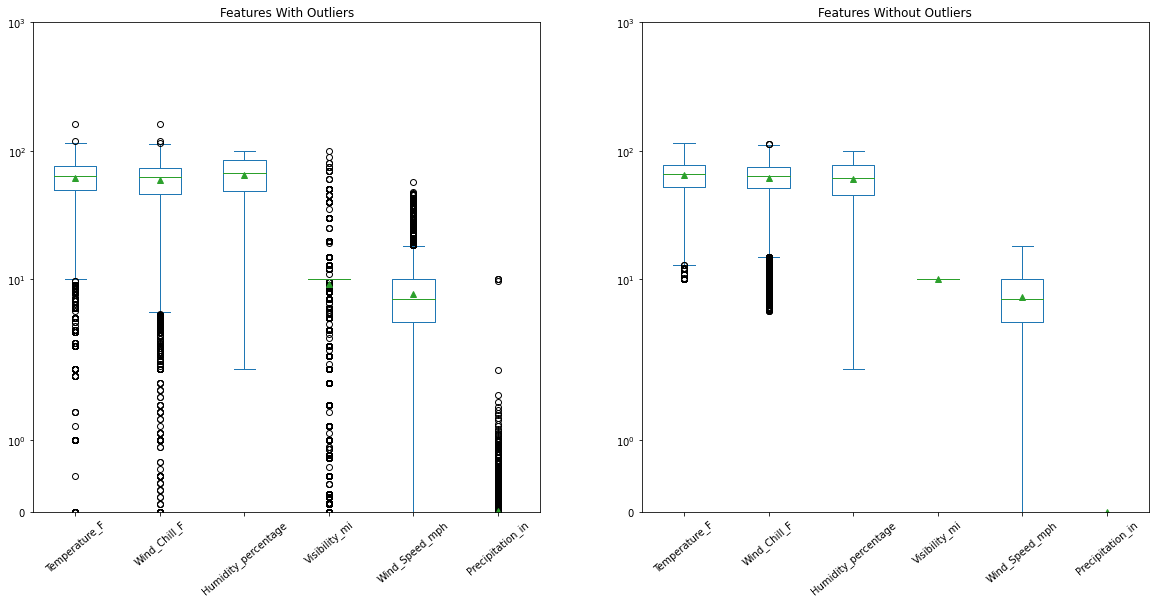

In [12]:
# DEALING WITH OUTLIERS

# Specify the features to check for outliers
features = ['Temperature_F', 'Wind_Chill_F', 'Humidity_percentage', 'Visibility_mi', 'Wind_Speed_mph', 'Precipitation_in']

# Create the first plot with outliers
fig, ax = plt.subplots(1, 2, figsize=(20, 9))
df[features].plot.box(ax=ax[0], rot=40, showmeans=True)
ax[0].set_title('Features With Outliers')  # Set the title for the first plot
ax[0].set_ylim(0, 1000)
ax[0].set_yscale('symlog')

# Drop the outliers using the IQR method
def remove_outliers_IQR_method(df, features):
    index_list = []

    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers_indexes = df.index[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
        index_list.extend(outliers_indexes)

    df = df.drop(index_list)

    return df

df = remove_outliers_IQR_method(df, features)

# Create the second plot without outliers
df[features].plot.box(ax=ax[1], rot=40, showmeans=True)
ax[1].set_title('Features Without Outliers')  # Set the title for the second plot
ax[1].set_ylim(0, 1000)
ax[1].set_yscale('symlog')

plt.show()

In [13]:
# Create a list of columns to consider for dropping rows
subset_columns = columns_to_fill + ['Weather_Timestamp_Year', 'Weather_Timestamp_Month', 'Weather_Timestamp_Day',
                                    'Weather_Timestamp_Weekday', 'Weather_Timestamp_Hour']

# Drop rows with missing values (NaN)
df.dropna(subset=subset_columns, inplace=True)

numeric_columns_with_nulls(df)

No exist any Numeric columns with Nan Values


**We prepare the object columns**

In [14]:
# Define the function to print unique values in object-type columns
def print_unique_col_values(df):
       for column in df:
            if df[column].dtypes=='object':
                print(f'{column}: {df[column].unique()}') 

print_unique_col_values(df)

Source: ['Source3' 'Source1' 'Source2']
County: ['Suffolk' 'San Luis Obispo' 'York' ... 'Chambers' 'Sharp' 'Cheboygan']
State: ['NY' 'CA' 'PA' 'TX' 'NC' 'FL' 'NJ' 'MI' 'MN' 'WA' 'MD' 'AZ' 'OK' 'IL'
 'SC' 'IA' 'OH' 'TN' 'LA' 'VA' 'AL' 'UT' 'OR' 'MA' 'ME' 'GA' 'MT' 'NE'
 'KS' 'WI' 'DE' 'CO' 'CT' 'NV' 'IN' 'MO' 'MS' 'NM' 'KY' 'DC' 'RI' 'ID'
 'AR' 'VT' 'WV' 'NH' 'WY' 'SD' 'ND']
Wind_Direction: ['N' 'CALM' 'South' 'NW' 'WNW' 'East' 'NE' 'SE' 'North' 'E' 'SSW' 'S' 'W'
 'ENE' 'SSE' 'ESE' 'West' 'Calm' 'VAR' 'WSW' 'NNE' 'SW' 'Variable' nan
 'NNW']
Sunrise_Sunset: ['Day' 'Night' nan]
Civil_Twilight: ['Day' 'Night' nan]
Nautical_Twilight: ['Day' 'Night' nan]
Astronomical_Twilight: ['Day' 'Night' nan]


In [15]:
# Drop the nan values from specific columns
df.dropna(subset=['Wind_Direction','Sunrise_Sunset','Civil_Twilight','Nautical_Twilight','Astronomical_Twilight'], inplace=True)

# Categorize the types of winds a little more briefly
df.loc[df['Wind_Direction']=='Calm','Wind_Direction'] = 'CALM'
df.loc[(df['Wind_Direction']=='West')|(df['Wind_Direction']=='WSW')|(df['Wind_Direction']=='WNW'),'Wind_Direction'] = 'W'
df.loc[(df['Wind_Direction']=='South')|(df['Wind_Direction']=='SSW')|(df['Wind_Direction']=='SSE'),'Wind_Direction'] = 'S'
df.loc[(df['Wind_Direction']=='North')|(df['Wind_Direction']=='NNW')|(df['Wind_Direction']=='NNE'),'Wind_Direction'] = 'N'
df.loc[(df['Wind_Direction']=='East')|(df['Wind_Direction']=='ESE')|(df['Wind_Direction']=='ENE'),'Wind_Direction'] = 'E'
df.loc[df['Wind_Direction']=='Variable','Wind_Direction'] = 'VAR'

# Encode
# Create to booleans with 0 and 1 the specific columns
df = df.replace([True, False], [1,0])
df = df.replace(["Day","Night"],[1,0])
df = df.replace(["R","L"],[1,0])

print_unique_col_values(df)

Source: ['Source3' 'Source1' 'Source2']
County: ['Suffolk' 'San Luis Obispo' 'York' ... 'St. Joseph' 'Chambers'
 'Cheboygan']
State: ['NY' 'CA' 'PA' 'TX' 'NC' 'FL' 'NJ' 'MI' 'MN' 'WA' 'MD' 'AZ' 'OK' 'IL'
 'SC' 'IA' 'OH' 'TN' 'LA' 'VA' 'AL' 'UT' 'OR' 'MA' 'ME' 'GA' 'MT' 'NE'
 'WI' 'DE' 'CO' 'CT' 'NV' 'IN' 'MO' 'MS' 'KS' 'NM' 'KY' 'DC' 'RI' 'ID'
 'AR' 'VT' 'WV' 'NH' 'WY' 'SD' 'ND']
Wind_Direction: ['N' 'CALM' 'S' 'NW' 'W' 'E' 'NE' 'SE' 'VAR' 'SW']


In [16]:
max(df.isna().sum())

0

In [17]:
# One-Hot Encode
# Specify the columns containing categorical/object values
object_values = ["State", "Wind_Direction", "County"]

# Convert the specified columns to categorical data type
df[object_values] = df[object_values].astype('category')

# Perform one-hot encoding on the categorical columns
df = pd.get_dummies(df, columns=object_values, drop_first=True)

In [18]:
df.shape

(72127, 1245)

In [19]:
df.head(3)

,Source,Severity,Start_Lat,Start_Lng,Distance_mi,Temperature_F,Wind_Chill_F,Humidity_percentage,Visibility_mi,Wind_Speed_mph,Precipitation_in,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Start_Year,Start_Month,Start_Weekday,Start_Day,Start_Hour,Start_Minute,End_Year,End_Month,End_Weekday,End_Day,End_Hour,End_Minute,Duration,Weather_Timestamp_Year,Weather_Timestamp_Month,Weather_Timestamp_Day,Weather_Timestamp_Weekday,Weather_Timestamp_Hour,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,State_DE,State_FL,State_GA,State_IA,State_ID,State_IL,State_IN,State_KS,State_KY,State_LA,State_MA,State_MD,State_ME,State_MI,State_MN,State_MO,State_MS,State_MT,State_NC,State_ND,State_NE,State_NH,State_NJ,State_NM,State_NV,State_NY,State_OH,State_OK,State_OR,State_PA,State_RI,State_SC,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY,Wind_Direction_E,Wind_Direction_N,Wind_Direction_NE,Wind_Direction_NW,Wind_Direction_S,Wind_Direction_SE,Wind_Direction_SW,Wind_Direction_VAR,Wind_Direction_W,County_Acadia,County_Accomack,County_Ada,County_Adair,County_Adams,County_Aiken,County_Aitkin,County_Alachua,County_Alamance,County_Alameda,County_Albany,County_Albemarle,County_Alexander,County_Alexandria,County_Alexandria (City),County_Allamakee,County_Allegan,County_Allegany,County_Alleghany,County_Allegheny,County_Allen,County_Allendale,County_Alpine,County_Amador,County_Amelia,County_Amherst,County_Anderson,County_Androscoggin,County_Angelina,County_Anne Arundel,County_Anoka,County_Anson,County_Apache,County_Appanoose,County_Appomattox,County_Arapahoe,County_Arenac,County_Arkansas,County_Arlington,County_Armstrong,County_Aroostook,County_Ascension,County_Ashland,County_Ashley,County_Athens,County_Atlantic,County_Attala,County_Auglaize,County_Augusta,County_Austin,County_Autauga,County_Baker,County_Baldwin,County_Baltimore,County_Baltimore City,County_Baltimore County,County_Bamberg,County_Barnstable,County_Barnwell,County_Barren,County_Barron,County_Barry,County_Bartholomew,County_Bartow,County_Bastrop,County_Bath,County_Bay,County_Beaufort,County_Beaver,County_Becker,County_Bedford,County_Bedford County,County_Belknap,County_Bell,County_Belmont,County_Beltrami,County_Benewah,County_Benton,County_Benzie,County_Bergen,County_Berkeley,County_Berks,County_Berkshire,County_Bernalillo,County_Berrien,County_Bertie,County_Bexar,County_Bibb,County_Big Horn,County_Billings,County_Bingham,County_Black Hawk,County_Bladen,County_Blaine,County_Blair,County_Bland,County_Bleckley,County_Bledsoe,County_Blount,County_Blue Earth,County_Bonneville,County_Boone,County_Bossier,County_Botetourt,County_Boulder,County_Bowie,County_Box Elder,County_Boyle,County_Bradford,County_Bradley,County_Braxton,County_Brazoria,County_Brazos,County_Brevard,County_Bristol,County_Bristol (City),County_Broadwater,County_Bronx,County_Brooks,County_Broome,County_Broomfield,County_Broward,County_Brown,County_Brunswick,County_Bryan,County_Buchanan,County_Buckingham,County_Bucks,County_Buena Vista,County_Bullitt,County_Bulloch,County_Buncombe,County_Bureau,County_Burke,County_Burleigh,County_Burlington,County_Butler,County_Butte,County_Butts,County_Cabarrus,County_Cabell,County_Caddo,County_Calaveras,County_Calcasieu,County_Caldwell,County_Calhoun,County_Callahan,County_Callaway,County_Calvert,County_Cambria,County_Camden,County_Cameron,County_Campbell,County_Canadian,County_Candler,County_Cannon,County_Canyon,County_Cape Girardeau,County_Cape May,County_Capitol,County_Carbon,County_Carlton,County_Caroline,County_Carroll,County_Carson City,County_Carson City (City),County_Carter,County_Carver,County_Cascade,County_Cass,County_Cassia,County_Caswell,County_Catawba,County_Catoosa,County_Cattaraugus,County_Cayuga,County_Cecil,County_Cedar,County_Centre,County_Chaffee,County_Chambers,County_Champaign,County_Cha

In [20]:
#----------------------
# Scaled in 0 and 1 with MinMaxScaler.
#----------------------

# Identify the numeric columns and the target
numeric_columns = df.select_dtypes(include=['float64', 'float32', 'int64']).columns
# Specify the target column
target = 'Severity'

# Exclude the columns that contain only 0 and 1 and it is not the target column
columns_to_scale = [col for col in numeric_columns if ((set(df[col].unique()) != {0, 1}) and (col != target))]

# Print the columns to be scaled
print(columns_to_scale)

# Scale the columns in the range of 0 and 1 using MinMaxScaler
scaler = MinMaxScaler()

# Apply scaling to the selected columns in the DataFrame
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

['Start_Lat', 'Start_Lng', 'Distance_mi', 'Temperature_F', 'Wind_Chill_F', 'Humidity_percentage', 'Visibility_mi', 'Wind_Speed_mph', 'Precipitation_in', 'Turning_Loop', 'Start_Year', 'Start_Month', 'Start_Weekday', 'Start_Day', 'Start_Hour', 'Start_Minute', 'End_Year', 'End_Month', 'End_Weekday', 'End_Day', 'End_Hour', 'End_Minute', 'Duration', 'Weather_Timestamp_Year', 'Weather_Timestamp_Month', 'Weather_Timestamp_Day', 'Weather_Timestamp_Weekday', 'Weather_Timestamp_Hour']


In [21]:
# Check if we have in df a not scaled column
for col in df.columns:
    if col == target:
        continue  # Skip the target column
    if df[col].dtype not in ['int64', 'float64']:
        continue  # Skip non-numeric columns
    if (df[col].max() > 1 or df[col].min() < 0):
        print(f"Column '{col}' is not scaled.")

In [22]:
min(df.Start_Lat), min(df.Start_Lng)

(0.0, 0.0)

In [23]:
max(df.Start_Lat), max(df.Start_Lng)

(1.0, 0.9999999999999998)

In [24]:
X = df.select_dtypes(include=['float64', 'int64'])  # Select only numeric columns
y = df['Severity']

# Convert to NumPy array and cast to float
X = X.to_numpy().astype('float')

In [25]:
# Split the data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'The split of data is this\n\nFor the train data:\n  X_train {X_train.shape}\n  y_train is {y_train.shape}\n\n'+
      f'For the test data:\n  X_test {X_test.shape}\n  y_test is {y_test.shape}')


The split of data is this

For the train data:
  X_train (57701, 45)
  y_train is (57701,)

For the test data:
  X_test (14426, 45)
  y_test is (14426,)


**Model1**

In [26]:
# Create the model.
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce = tf.keras.callbacks.ReduceLROnPlateau()

history = model.fit(X_train, y_train, batch_size=32,epochs=25,verbose=5,validation_split=0.2, callbacks=[earlyStopping, reduce])



Epoch 1/25


Epoch 2/25
Epoch 3/25
Epoch 4/25
Epoch 5/25
Epoch 6/25
Epoch 7/25
Epoch 8/25
Epoch 9/25
Epoch 10/25
Epoch 11/25
Epoch 12/25


**Model2**

In [27]:
# Split the data to train and test
X_model2_train, X_model2_test, y_model2_train, y_model2_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'The split of data is this\n\nFor the train data:\n  X_train {X_model2_train.shape}\n  y_train is {y_model2_train.shape}\n\n'+
      f'For the test data:\n  X_test {X_model2_test.shape}\n  y_test is {y_model2_test.shape}')

The split of data is this

For the train data:
  X_train (57701, 45)
  y_train is (57701,)

For the test data:
  X_test (14426, 45)
  y_test is (14426,)


In [28]:
# Create the SVM model with adjusted hyperparameters
# C is the penalty parameter that controls the trade-off between misclassification of training examples and smooth decision boundaries
# A smaller C value allows for more misclassifications but can lead to a wider margin and potentially better generalization
# A larger C value tries to minimize the misclassifications at the expense of a narrower margin
svm_model = LinearSVC(C=100, max_iter=1000)

# Lists to store accuracy and loss values
train_accuracy = []
val_accuracy = []
train_loss = []
val_loss = []
num_epochs = 10

# Iterate over epochs or iterations during training
for epoch in range(num_epochs):
    # Perform training for the current epoch/iteration
    svm_model.fit(X_model2_train, y_model2_train)
    
    # Calculate training accuracy and loss
    train_pred = svm_model.predict(X_model2_train)
    train_acc = accuracy_score(y_model2_train, train_pred)
    train_accuracy.append(train_acc)
    train_loss.append(mean_squared_error(y_model2_train, train_pred))
    
    # Calculate validation accuracy and loss
    val_pred = svm_model.predict(X_model2_test)
    val_acc = accuracy_score(y_model2_test, val_pred)
    val_accuracy.append(val_acc)
    val_loss.append(mean_squared_error(y_model2_test, val_pred))

E:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
E:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
E:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
E:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
E:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
E:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
E:\Anaconda\lib\site-packages\sklearn\svm\_bas

**Evaluate the Models**

In [29]:
# Make predictions on test set
svm_pred = svm_model.predict(X_model2_test)

In [30]:
print('Test Loss of Model is ',  model.evaluate(X_test, y_test)[0] ,'  |  Test Accuracy is ', model.evaluate(X_test, y_test)[1],'\n\n')


print('Test Accuracy of SVM Model is ', accuracy_score(y_model2_test,svm_pred)*100)

451/451 [==============================] - 1s 2ms/step - loss: 3.1612e-05 - accuracy: 1.0000
Test Loss of Model is  3.1612245948053896e-05   |  Test Accuracy is  1.0 


Test Accuracy of SVM Model is  96.74892555108832


In [31]:
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1) #Predicted Class Value
print('\nFor Model:\n',y_pred,'\n\n')

print('For SVM Model:\n',svm_pred,'\n\n')

451/451 [==============================] - 2s 2ms/step

For Model:
 [2 2 2 ... 2 3 2] 


For SVM Model:
 [2 2 2 ... 2 3 2] 




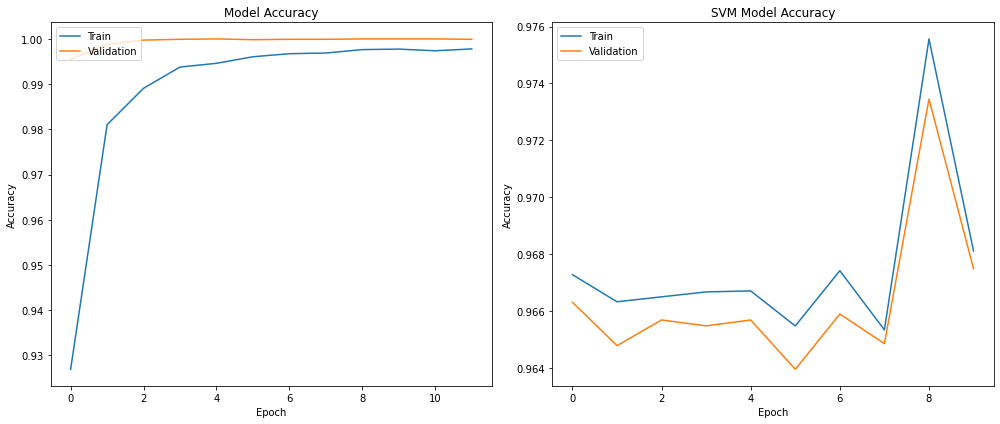

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# PLOT TRAINING AND VALIDATION ACCURACY VALUES | Model
axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('Model Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(['Train', 'Validation'], loc='upper left')

# PLOT TRAINING AND VALIDATION ACCURACY VALUES | Model2
axs[1].plot(range(num_epochs), train_accuracy, label='Train')
axs[1].plot(range(num_epochs), val_accuracy, label='Validation')
axs[1].set_title('SVM Model Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


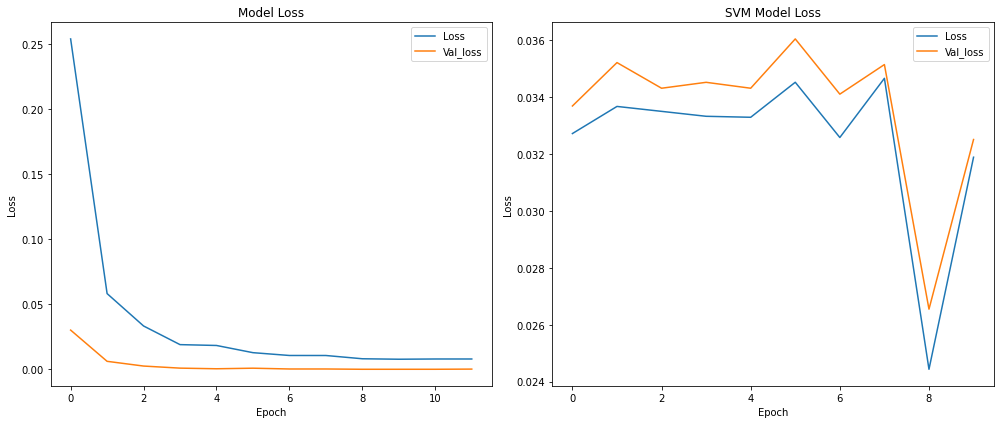

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

#PLOT TRAINING AND VALIDATION LOSS VALUES | Model
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].set_title('Model Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend(['Loss' , 'Val_loss'] , loc='upper right')

#PLOT TRAINING AND VALIDATION LOSS VALUES | Model2
axs[1].plot(range(num_epochs), train_loss, label='Train')
axs[1].plot(range(num_epochs), val_loss, label='Validation')
axs[1].set_title('SVM Model Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(['Loss' , 'Val_loss'] , loc='upper right')

plt.tight_layout()
plt.show()


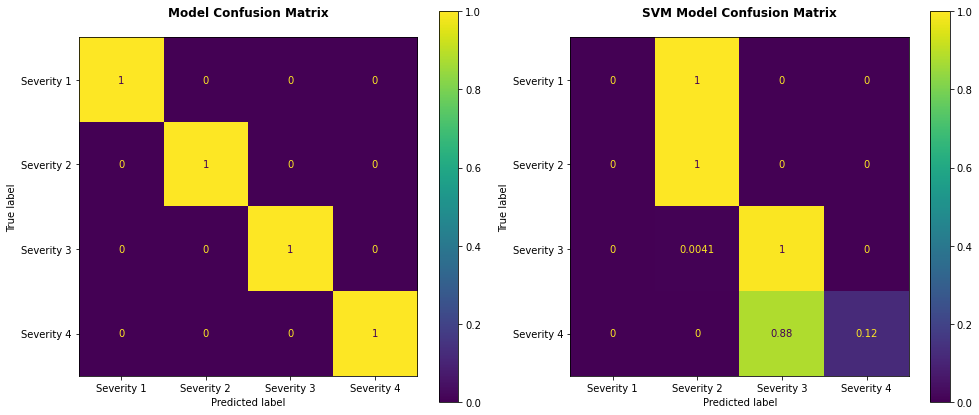

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# PLOT CONFUSION METRIX | Model
mat1 = metrics.confusion_matrix(y_test, y_pred, normalize='true')
cm_display1 = metrics.ConfusionMatrixDisplay(confusion_matrix=mat1, display_labels=['Severity 1', 'Severity 2', 'Severity 3', 'Severity 4'])
cm_display1.plot(ax=axs[0])
axs[0].set_title('Model Confusion Matrix\n',fontweight='bold')

# PLOT CONFUSION METRIX | Model2
mat1 = metrics.confusion_matrix(y_model2_test, svm_pred, normalize='true')
cm_display1 = metrics.ConfusionMatrixDisplay(confusion_matrix=mat1, display_labels=['Severity 1', 'Severity 2', 'Severity 3', 'Severity 4'])
cm_display1.plot(ax=axs[1])
axs[1].set_title('SVM Model Confusion Matrix\n',fontweight='bold')

plt.tight_layout()
plt.show()